In [1]:
# Import packages
import sys
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from natsort import natsorted
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer,Input, Dense, Dropout, Activation, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow.keras.metrics
####import tensorflow_addons as tfa not required
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical, plot_model
# from pycm import *
#import matplotlib.pyplot as plt

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score
from sklearn.metrics import f1_score, auc, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import r2_score

ROOT = '/mnt/media/dnndr2/finalEmbs/'

# View all available embeddings
for f in os.listdir(ROOT):
    print(f)
    
# Chosoe emb from 
# ['esm1', 'esm1b', 'esm1v','ProtBert','ProtBert_BFD', 'Prot_T5_XL', 'Prot_T5_XL_BFD',
#                  'Prot_XLNet', 'ProtAlbert', 'alphafold']
emb = 'ProtAlbert'

X_protein_esm1.npy
X_drug.npy
yreg.npy
X_protein_esm1v.npy
X_protein_Prot_T5_XL_BFD.npy
X_protein_ProtBert_BFD.npy
y.npy
X_protein_ProtAlbert.npy
X_protein_esm1b.npy
train_dnndr2_v2.ipynb
X_protein_Prot_XLNet.npy
X_protein_Prot_T5_XL.npy
X_protein_ProtBert.npy


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# REGRESSION

In [3]:
# DATA
X_protein = np.load(ROOT+'X_protein_%s.npy'%(emb))
#X_drug = np.random.rand(61624, 1024)
X_drug = np.load(ROOT+'X_drug.npy')
y = np.load(ROOT+'yreg.npy')
y = y.reshape(-1,1)
y = np.log10(y+0.000000001)

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X_protein, X_drug, y, test_size=0.33, random_state=42)
print(X1_train.shape, X2_train.shape, y_train.shape, X1_test.shape, X2_test.shape, y_test.shape)

(41288, 4096) (41288, 1024) (41288, 1) (20336, 4096) (20336, 1024) (20336, 1)


In [4]:
### regression model
####model MLP  

##################
# 1: it works good

#input_1 protien
input_1 = Input(shape = (4096,), name='i_1')  ### ProtAlbert
#bn1_0 = BatchNormalization()(input_1)
dense1_1 = Dense(1024, activation = 'relu')(input_1)
bn1_1 = BatchNormalization()(dense1_1)
#dense1_2 = Dense(1024, activation = 'relu')(bn1_1)
#bn1_2 = BatchNormalization()(dense1_2)

#input_2 drug
input_2 = Input(shape = (1024,), name='i_2')
#bn2_0 = BatchNormalization()(input_2)
dense2_1 = Dense(1024, activation = 'relu')(input_2)
bn2_1 = BatchNormalization()(dense2_1)
#dense2_2 = Dense(1024, activation = 'relu')(bn2_1)
#bn2_2 = BatchNormalization()(dense2_2)
 
# concatenate
##concat   = Concatenate()([dense1_1, dense2_1])
concat   = Concatenate()([bn1_1, bn2_1])
fc_1   = Dense(1024, activation = 'relu')(concat)
drop_1 = Dropout(0.5)(fc_1)
fc_2   = Dense(512, activation = 'relu')(drop_1)

#regression output
output  = Dense(1, activation='linear')(fc_2)
 
# create model with two inputs
model = Model(inputs=[input_1,input_2], outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i_1 (InputLayer)                [(None, 4096)]       0                                            
__________________________________________________________________________________________________
i_2 (InputLayer)                [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         4195328     i_1[0][0]                        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         1049600     i_2[0][0]                        
______________________________________________________________________________________________

In [5]:
import tensorflow_addons as tfa
###### reg setup
#### reg
model.compile(loss='mse', 
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['mse', 'mae',
                       tfa.metrics.r_square.RSquare(name='r2',dtype=tf.float32, y_shape=(1,))
                       ])

reduce_lr = ReduceLROnPlateau(monitor='val_r2', factor=0.9,patience=20, min_lr=0.00000001, verbose=1)
checkpoint_filepath = 'checkpoints/weights-improvement-{val_r2:.3f}_random_reg.hdf5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_mse',mode='min',save_best_only=True)

# regression fit the keras model on the dataset
history=model.fit([X1_train,X2_train],y_train,
                  batch_size=2048, epochs=400,
                  validation_data=([X1_test,X2_test],y_test),
                  #validation_split=0.1,
                  #class_weight=class_weights,
                  #class_weight={0: 2.818, 1: 0.714, 2: 0.802},
                  callbacks=[reduce_lr,model_checkpoint_callback
                             ], verbose=0)


Epoch 00022: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 8.100000122794882e-05.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-05.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 6.56100019114092e-05.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 5.904900172026828e-05.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 5.314410154824145e-05.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 4.7829690083744934e-05.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 4.304672074795235e-05.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 3.8742047036066654e-05.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 3.4867842987296176e-05.

Epoch 00222: ReduceLROnPlateau reducing learning rate to 3.138105967082083e-05.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 2.824295370373875e-05.

Epoch 00262: ReduceLROnPl

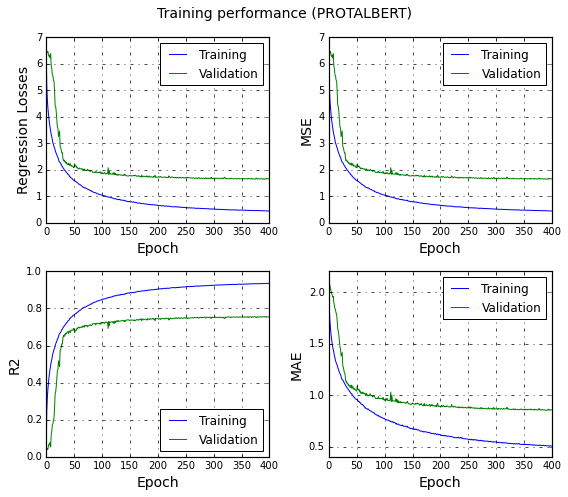

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.linewidth'] = 1.2

fig, ax = plt.subplots(2,2, figsize=(8,7))
ax[0][0].plot(history.history['loss'], label='Training')
ax[0][0].plot(history.history['val_loss'], label='Validation')
ax[0][0].legend()
ax[0][0].set_ylabel('Regression Losses', fontsize='14')
ax[0][0].set_xlabel('Epoch', fontsize='14')
ax[0][0].grid(linestyle='-.', linewidth=0.7)

ax[0][1].plot(history.history['mse'], label='Training')
ax[0][1].plot(history.history['val_mse'], label='Validation')
ax[0][1].legend()
ax[0][1].set_ylabel('MSE', fontsize='14')
ax[0][1].set_xlabel('Epoch', fontsize='14')
ax[0][1].grid(linestyle='-.', linewidth=0.7)

ax[1][0].plot(history.history['r2'], label='Training')
ax[1][0].plot(history.history['val_r2'], label='Validation')
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylabel('R2', fontsize='14')
ax[1][0].set_xlabel('Epoch', fontsize='14')
ax[1][0].grid(linestyle='-.', linewidth=0.7)

ax[1][1].plot(history.history['mae'], label='Training')
ax[1][1].plot(history.history['val_mae'], label='Validation')
ax[1][1].legend()
ax[1][1].set_ylabel('MAE', fontsize='14')
ax[1][1].set_xlabel('Epoch', fontsize='14')
ax[1][1].grid(linestyle='-.', linewidth=0.7)

fig.suptitle("Training performance (%s)"%(emb.upper()), fontsize=14)
plt.tight_layout()
#plt.savefig('plots/training_random_reg_true_prot.png', dpi=600, transparent=False, bbox_inches='tight')

In [7]:
# #### regression
y_train_pred= model.predict([X1_train,X2_train])
y_test_pred = model.predict([X1_test,X2_test])

#### regression predictions
result_trainr2 = r2_score(y_train, y_train_pred)
result_testr2 = r2_score(y_test, y_test_pred)

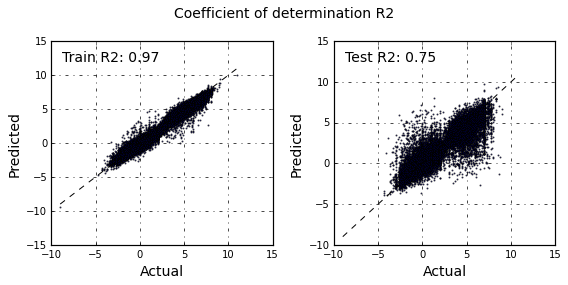

In [8]:
###plots
mpl.rcParams['axes.linewidth'] = 1.2

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(y_train, y_train_pred,s=1,alpha=0.7)
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax[0].set_ylabel('Predicted', fontsize='14')
ax[0].set_xlabel('Actual', fontsize='14')
ax[0].grid(linestyle='-.', linewidth=0.7)
ax[0].text(0.05, 0.9, 'Train R2: ' + str(np.round(result_trainr2, 2)), fontsize=14, transform=ax[0].transAxes)

ax[1].scatter(y_test, y_test_pred,s=1,alpha=0.7)
ax[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax[1].set_ylabel('Predicted', fontsize='14')
ax[1].set_xlabel('Actual', fontsize='14')
ax[1].grid(linestyle='-.', linewidth=0.7)
ax[1].text(0.05, 0.9, 'Test R2: ' + str(np.round(result_testr2, 2)), fontsize=14, transform=ax[1].transAxes)

fig.suptitle("Coefficient of determination R2", fontsize=14)
plt.tight_layout()
#plt.savefig('R2_random_reg_true_prot.png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()

# CLASSIFICATION

In [11]:
# DATA
X_protein = np.random.rand(61624, 4096)
X_drug = np.random.rand(61624, 1024)
y = np.load(ROOT+'y.npy')

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X_protein, X_drug, y, test_size=0.33, random_state=42)
print(X1_train.shape, X2_train.shape, y_train.shape, X1_test.shape, X2_test.shape, y_test.shape)

(41288, 4096) (41288, 1024) (41288, 3) (20336, 4096) (20336, 1024) (20336, 3)


In [12]:
#@title Classification model
####model MLP  Classification

##################
# 1: it works good

#input_1 protien
input_1 = Input(shape = (4096,), name='i_1')  ### ProtAlbert

#input_1 = Input(shape = (15599,), name='i_1')
#bn1_0 = BatchNormalization()(input_1)
dense1_1 = Dense(1024, activation = 'elu')(input_1)
bn1_1 = BatchNormalization()(dense1_1)
#dense1_2 = Dense(1024, activation = 'relu')(bn1_1)
#bn1_2 = BatchNormalization()(dense1_2)

#input_2 drug
input_2 = Input(shape = (1024,), name='i_2')
#bn2_0 = BatchNormalization()(input_2)
dense2_1 = Dense(1024, activation = 'elu')(input_2)
bn2_1 = BatchNormalization()(dense2_1)
#dense2_2 = Dense(1024, activation = 'relu')(bn2_1)
#bn2_2 = BatchNormalization()(dense2_2)
 
# concatenate
##concat   = Concatenate()([dense1_1, dense2_1])
#concat   = Concatenate()([bn1_2, bn2_2])
concat   = Concatenate()([bn1_1, bn2_1])
fc_1   = Dense(1024, activation = 'elu')(concat)
drop_1 = Dropout(0.5)(fc_1)
fc_2   = Dense(512, activation = 'elu')(drop_1)
#drop_2 = Dropout(0.5)(fc_1)
#fc_3   = Dense(1024, activation = 'relu')(drop_2)
#classification output
output  = Dense(3, activation='softmax')(fc_2)
 
# create model with two inputs
model = Model(inputs=[input_1,input_2], outputs=output)

In [14]:
#@title classfication metrics
metrics_c = ['accuracy',
    #keras.metrics.FalseNegatives(name="fn"),
    #keras.metrics.FalsePositives(name="fp"),
    #keras.metrics.TrueNegatives(name="tn"),
    #keras.metrics.TruePositives(name="tp"),
    #keras.metrics.BinaryAccuracy(name='accuracy'),
    tensorflow.keras.metrics.Precision(name="precision"),
    tensorflow.keras.metrics.Recall(name="recall"),
    tensorflow.keras.metrics.AUC(name="auc_pr",curve="PR"),
    tensorflow.keras.metrics.AUC(name="auc_roc",curve="ROC")
]

## classi
model.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=metrics_c)
##class
reduce_lr = ReduceLROnPlateau(monitor='val_auc_pr', factor=0.5,patience=20, min_lr=0.00000001, verbose=1)

### class setup
###checkpoint_filepath = 'weights-improvement-{epoch:03d}-{val_auc_pr:.4f}.hdf5'
checkpoint_filepath = 'checkpoints/weights-improvement-{val_auc_pr:.3f}_random_classification.hdf5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,
                                            monitor='val_auc_pr',
                                            mode='max',
                                            save_best_only=True)

In [15]:
# classification fit the keras model on the dataset
history=model.fit([X1_train,X2_train],y_train,
                  batch_size=2048, epochs=100,
                  validation_data=([X1_test,X2_test],y_test),
                  #validation_split=0.1,
                  #class_weight=class_weights,
                  #class_weight={0: 2.818, 1: 0.714, 2: 0.802},
                  callbacks=[reduce_lr,model_checkpoint_callback], verbose=0)


Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


In [18]:
##### predictions
y_pred = model.predict([X1_test,X2_test]) ###classification

y_act = np.argmax(y_test, axis=1)
y_mod = np.argmax(y_pred, axis=1)


###
res_list = roc_auc_score(y_test, y_pred, average=None, multi_class='ovr').tolist()+ \
      average_precision_score(y_test, y_pred, average=None).tolist()+ \
      [matthews_corrcoef(y_act, y_mod)]+[cohen_kappa_score(y_act, y_mod)]

print(*res_list, sep=",")

# Compute ROC/AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# compute PR/AUPR
precision, recall, average_precision = dict(), dict(), dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred, average="micro")

0.5010278683442844,0.4942213204237626,0.495743708371905,0.11802133844529211,0.4610142284268428,0.412385209844807,-0.005663436749217821,-0.005607782974629716


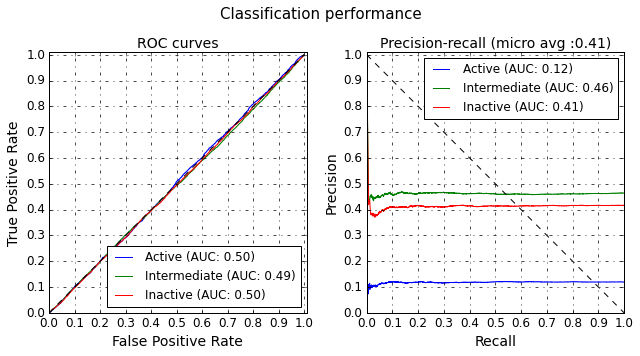

In [20]:
###plots
fig, ax = plt.subplots(1,2,figsize=(9,5))

for i, activity in zip(range(3),['Active', 'Intermediate','Inactive']):
    ax[0].plot(fpr[i], tpr[i], label=activity+' (AUC: %0.2f)' % roc_auc[i], alpha=1)
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_ylim([0.0, 1.01])
ax[0].set_xlim([0.0, 1.01])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].set_xticks(np.arange(0, 1.1, 0.1))
ax[0].set_title('ROC curves', fontsize=14)
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)

ax[0].tick_params(axis="x", labelsize=12)
ax[0].tick_params(axis="y", labelsize=12) 
ax[0].grid(linestyle='-.', linewidth=0.7)
ax[0].legend(fontsize=12, loc='lower right')

# ############### auPR plot
for i, activity in zip(range(3),['Active', 'Intermediate','Inactive']):
    ax[1].plot(recall[i],precision[i], label=activity+' (AUC: %0.2f)' % average_precision[i], alpha=1)
##################################
#ax[1].step(recall['micro'], precision['micro'], where='post')
ax[1].set_xlabel('Recall', fontsize=14)
ax[1].set_ylabel('Precision', fontsize=14)
ax[1].plot([0, 1], [1, 0], 'k--')
ax[1].set_ylim([0.0, 1.01])
ax[1].set_xlim([0.0, 1.00])
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_xticks(np.arange(0, 1.1, 0.1))
ax[1].set_title('Precision-recall (micro avg :{0:0.2f})'.format(average_precision["micro"]), fontsize=14)
ax[1].tick_params(axis="x", labelsize=12)
ax[1].tick_params(axis="y", labelsize=12) 
ax[1].grid(linestyle='-.', linewidth=0.7)
ax[1].legend(fontsize=12, loc='upper right')
fig.suptitle("Classification performance", fontsize=15)
plt.tight_layout()
plt.savefig('roc_auc_random_classification.png', dpi=600, transparent=False, bbox_inches='tight')